# ARG inference with tsinfer

## Overview

Many ARG inference methods are available that lie somewhere on a spectrum between inference accuracy and scalability. `tsinfer` is scalable to over 100 000 whole human genomes, does not require any demographic modeling assumptions and supports a variety of data formats. The biggest drawback is that it only produces a single, deterministic estimate of the ARG's topology, without a measure of uncertainty. However, branch lengths are estimated by another package, `tsdate`, which estimates branch lengths probabilistically with a Bayesian method.

This workshop aims to introduce you to ARG inference using the Python packages `tsinfer` and `tsdate`. Working with a subset of the 1000 Genomes Project data in VCF format, we will show how to convert the data into a more useful format and run through the inference process. Finally, we will demonstrate the use of the `tsbrowse` tool for quality controlling an inferred ARG.

<div class="alert alert-block alert-info">
  <b>Note:</b> For practical reasons, the dataset we are working with is small enough to quickly analyse on an ordinary laptop. For large datasets, where parallel computation on a High Performance Computing Cluster is essential, we have developed a 
  <a href="https://github.com/benjeffery/tsinfer-snakemake/">Snakemake pipeline</a>
  to manage the entire inference process.
</div>

## Outline of the workshop

1. Convert the VCF to Zarr format  
2. Create the ancestral allele array  
3. Inference with `tsinfer`  
   3.1. Loading the data  
   3.2. Generate ancestors  
   3.3. Match ancestors
   3.4. Match samples  
4. Dating the ARG with `tsdate`  
5. Quality control with `tsbrowse`


## 1. Converting the VCF to Zarr format

The VCF format has severe limitations as a genetic data format, especially for large datasets. Extracting data from a particular field is inefficient and it does not lend itself to distributed computing. The **VCF Zarr format**, described in [this preprint](https://www.biorxiv.org/content/10.1101/2024.06.11.598241v3), addresses these limitations, making it easy to slice the data and perform parallel computations efficiently.  

**Zarr** is a general format for storing multi-dimensional data, so there are many libraries available to work with it. We will focus on tools specialised for working with VCF Zarr data specifically. The Python package <code>bio2zarr</code> can convert VCF, plink and tskit ARGs into the format, while `sgkit` offers tools for analysing and manipulating the data.

As discussed in the [<code>bio2zarr</code> documentation](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html#sec-vcf2zarr-tutorial), converting the VCF to Zarr is a two-step process for moderately-sized datasets. We will do it with the Command Line Interface. First, we **explode** the vcf into the Intermediate Column Format. This separates out the fields (columns) of the VCF:

In [79]:
%%bash
vcf2zarr explode -f data/vcf/tgp.vcf.gz data/zarr/tgp.icf

    Scan: 100%|██████████| 1.00/1.00 [00:00<00:00, 2.97files/s]
 Explode: 100%|██████████| 8.11k/8.11k [00:03<00:00, 2.05kvars/s]


Now we can <code>inspect</code> the ICF we have created, which tells us about the fields in the input VCF:

In [80]:
%%bash
vcf2zarr inspect data/zarr/tgp.icf

name       type       chunks  size       compressed      max_n  min_val    max_val
---------  -------  --------  ---------  ------------  -------  ---------  ---------
CHROM      String          2  1.73 MiB   598 bytes           1  n/a        n/a
POS        Integer         2  1.73 MiB   29.13 KiB           1  6e+06      7e+06
QUAL       Float           2  253.5 KiB  120 bytes           0  n/a        n/a
ID         String          2  1.73 MiB   19.24 KiB           1  n/a        n/a
FILTERS    String          2  1.98 MiB   920 bytes           1  n/a        n/a
REF        String          2  1.73 MiB   12.06 KiB           1  n/a        n/a
ALT        String          2  1.79 MiB   12.04 KiB           1  n/a        n/a
rlen       Integer         2  1.73 MiB   646 bytes           1  1          1
FORMAT/GT  Integer         2  11.26 MiB  235.33 KiB          3  0          1


Minimum and maximum values of numerical fields are shown, so we can see that this is a 1mbp region from 6-7 mbp. At this stage, we choose how we want to encode the ICF to a Zarr by adjusting the **schema**, which allows us to remove fields and make other changes. We don't need to here, but [see the `vcf2zarr` tutorial](https://sgkit-dev.github.io/bio2zarr/vcf2zarr/tutorial.html) if you're interested. 

The final step is to <code>encode</code> the ICF into a Zarr. Since we are not making any changes to the schema, this is a simple command:

In [81]:
%%bash
vcf2zarr encode -f data/zarr/tgp.icf data/zarr/tgp.zarr

  Encode: 100%|██████████| 4.35M/4.35M [00:01<00:00, 3.29MB/s]
Finalise: 100%|██████████| 11.0/11.0 [00:00<00:00, 938array/s]


We can again use <code>inspect</code> to check our results:

In [82]:
%%bash
vcf2zarr inspect data/zarr/tgp.zarr

name                   dtype    stored      size          ratio    nchunks  chunk_size               avg_chunk_stored    shape           chunk_shape     compressor                                                      filters
---------------------  -------  ----------  ----------  -------  ---------  -----------------------  ------------------  --------------  --------------  --------------------------------------------------------------  ------------
/call_genotype         int8     119.12 KiB  1.55 MiB    13               9  176.04 KiB               13.24 KiB           (8112, 100, 2)  (1000, 100, 2)  Blosc(cname='zstd', clevel=7, shuffle=BITSHUFFLE, blocksize=0)  None
/call_genotype_mask    bool     76.93 KiB   1.55 MiB    21               9  176.04 KiB               8.55 KiB            (8112, 100, 2)  (1000, 100, 2)  Blosc(cname='zstd', clevel=7, shuffle=BITSHUFFLE, blocksize=0)  None
/variant_allele        object   47.66 KiB   126.75 KiB   2.7             9  14.08 KiB                

Zarr arrays are automatically divided into chunks to aid parallel computation. We can see that the genotype matrix is encoded in a 3D array (<code>call_genotype</code>) with dimensions <code>num_sites</code> x <code>num_samples</code> x <code>ploidy</code>.


<div class="alert alert-block alert-info"><b>Note</b>: for small datasets, a convenience function (<code>convert</code>) is available to do the conversion in one step in Python or with the CLI. For very large datasets, functions are also available to distribute the encoding/decoding across multiple nodes.</div>

## 2. Create the ancestral allele array

`tsinfer` requires that variants are **bi-allelic**, **phased** and have a **known ancestral state**. Many methods are available to estimate ancestral alleles. In the case of humans, ancestral FASTA sequences, calculated with a tool called Orpheus, are available online. The dataset we are working with has already been polarised with this method, such that the first (reference) allele is always ancestral.

If you have **tri-allelic** variants, they can be masked out for inference and added back into the ARG at the end, by parsimony.

We still need to provide `tsinfer` with the ancestral allele array. To do this, we need to access the VCF Zarr dataset. The easiest way to do this is with the `sgkit` package:


In [2]:
import sgkit

ds = sgkit.load_dataset("data/zarr/tgp.zarr")
ds


<xarray.Dataset> Size: 4MB
Dimensions:               (variants: 8112, samples: 100, ploidy: 2, contigs: 1,
                           filters: 1, region_index_values: 9,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 2MB dask.array<chunksize=(1000, 100, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2MB dask.array<chunksize=(1000, 100, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 811kB dask.array<chunksize=(1000, 100), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_description    (filters) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                    ...
    variant_filter        (variants, filters) bool 8kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    variant_id            (variants) object 65kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 8kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int8 8kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 32kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 32kB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:                bio2zarr-0.1.6
    vcf_meta_information:  [['fileformat', 'VCFv4.2'], ['source', 'tskit 0.6....
    vcf_zarr_version:      0.4

All array dimensions have names and the variables are stored as an `xarray`, since this allows for chunking of the arrays. For example:

In [3]:
ds.variant_allele

<xarray.DataArray 'variant_allele' (variants: 8112, alleles: 2)> Size: 130kB
dask.array<open_dataset-variant_allele, shape=(8112, 2), dtype=object, chunksize=(1000, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, alleles
Attributes:
    description:  List of the reference and alternate alleles

We can convert any xarray into a simple numpy array with `.values`

In [4]:
variant_allele = ds.variant_allele.values
variant_allele

array([['A', 'C'],
       ['T', 'C'],
       ['A', 'G'],
       ...,
       ['T', 'C'],
       ['C', 'T'],
       ['G', 'T']], dtype=object)

In this 2D array, the left column is `REF` and the right column is `ALT`. As mentioned previously, the `REF` alleles are ancestral so we just need to slice them out

In [5]:
ancestral_state = variant_allele[:,0]
ancestral_state

array(['A', 'T', 'A', ..., 'T', 'C', 'G'], dtype=object)

At this stage, we could store this array in the Zarr, but in our case it is easier to just pass it directly into `tsinfer`.
While we're here, we can check what the allele frequency spectrum looks like by summing out the ploidy and samples dimensions of the genotype matrix:

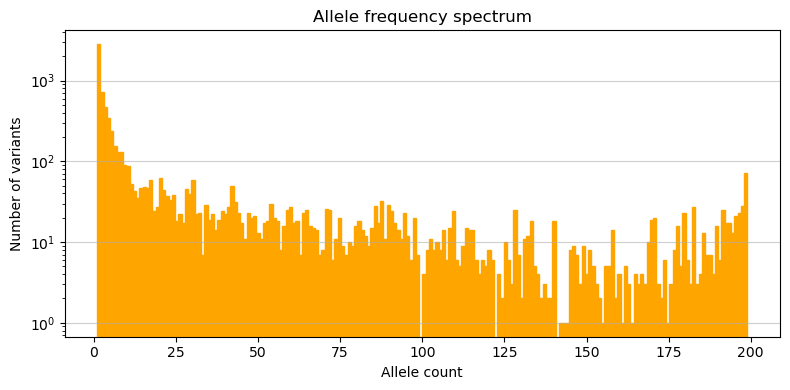

In [12]:
import numpy as np
import matplotlib.pyplot as plt

ac = np.sum(ds.call_genotype.values, axis=(1, 2))
plt.figure(figsize=(8, 4))
plt.hist(ac, bins=200, color='orange', edgecolor='orange')
plt.title('Allele frequency spectrum')
plt.xlabel('Allele count')
plt.ylabel('Number of variants')
plt.yscale('log')
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()

plt.show()

Notice that we have over a thousand singletons! These are perfectly phased, because they have a higher frequency in the broader 1000 Genomes Project dataset.

## 3. Inference with `tsinfer`

### 3.1. Loading in the data

To start inference, we need to load the data into `tsinfer` via the `VariantData` class, which is just a wrapper of a zarr. To specify the ancestral states, we can either point it to a variable in the Zarr or provide the array directly as we will.

In [17]:
import tsinfer

variant_data = tsinfer.VariantData("data/zarr/tgp.zarr", ancestral_state=ancestral_state)
variant_data.num_sites

np.int64(8112)

We can still access the data in the zarr, which is accessible in `variant_data.data`. 

### 3.2. Generate ancestors

The first step of `tsinfer`, ancestor generation, uses the genotype data to estimate the ancestral haplotypes that the samples inherited from. For a given set of inference sites with the same allele frequency and genotypes, which we call **focal sites**, we create an ancestor that carries the derived mutation, extending to the left and right until a stopping criterion is reached.

The result of ancestor generation is an object called `AncestorData`, which contains all the inferred ancestral haplotypes

In [18]:
anc_data = tsinfer.generate_ancestors(variant_data, progress_monitor=True)
print(f'Generated {anc_data.num_ancestors} ancestors from {variant_data.num_sites} sites')

ga-add   (1/2)100%|██████████| 8.11k/8.11k [00:00, 31.2kit/s]
ga-gen   (2/2)100%|██████████| 3.17k/3.17k [00:00, 10.2kit/s]

Generated 3168 ancestors from 8112 sites


For what follows, ancestors need to have a measure of relative age, so that we can match their haplotypes against each other. The default is to use **allele frequency as a proxy of relative age**, since we expect rare mutations to have occurred more recently than common ones. 

We usually don't do any QC or analysis of the ancestor data at this stage except for development purposes.

<div class="alert alert-block alert-info"><b>Note</b>: Ancestor generation is usually much faster than the subsequent steps (ancestor matching and sample matching). The only potential issue is that it can be RAM intensive for large datasets, since the 1-bit encoded genotype matrix needs to fit in RAM. </div>

### 3.3. Match ancestors

We next need to match the ancestral haplotypes against each other to form an **ancestors tree sequence/ARG**. This ARG captures all the copying patterns between the ancestors, but does not include the sample haplotypes. `tsinfer` uses the [Li and Stephens (2003) Hidden Markov Model (HMM)](https://pubmed.ncbi.nlm.nih.gov/14704198/) for matching. We will not discuss its parameters here, since we strongly advise using the defaults for this step.

The `match_ancestors` function needs both the `VariantData` and `AncestorData` to run, so the call looks like


In [19]:
ancestors_arg = tsinfer.match_ancestors(variant_data, anc_data, progress_monitor=False)
ancestors_arg

Curiously, there are 1341 sample nodes, one for each ancestor. This is because we haven't added the actual samples yet. We usually don't QC the ancestor ARG directly, so we will proceed to the final stage.

### 3.4. Match samples


The final inference step is to match the sample haplotypes against the ancestors ARG, which will complete the ARG topology. For best results, it is best to specify a **recombination rate**, which can be either be:

1. A floating point recombination rate $\rho$ per unit length of genome
2. A recombination map stored as an `msprime.RateMap` object.

If you have a recombination rate map available, as is the case for humans, it is worth using. We have provided the HapMap for chromosome 20 to use with our data, so we need to use `msprime` to load it in

In [21]:
import msprime

hapmap_path = "data/hapmap/genetic_map_Hg38_chr20.txt"
rate_map = msprime.RateMap.read_hapmap(hapmap_path, position_col=1, rate_col=2)

Whenever a recombination rate is provided, you can also specify a `mismatch_ratio`, which determines the balance between recombination events and recurrent mutations. If a mismatch is encountered at a site between otherwise closely matching haplotypes, the HMM will

- Always add a recombination event if `mismatch_ratio  = 0` (default)
- Be equally likely to add a recombination event or recurrent mutation if `mismatch_ratio = 1`
- Be two times more likely to add a recurrent mutation if `mismatch_ratio = 2`

We advise setting mismatch to zero in the first instance, which makes inference much faster and results in no recurrent mutations being added. If you do set it to a non-zero value, it is best to make it very small ($\leq 10^{-3}$), otherwise an excessively many recurrent mutations will be added.

In [22]:
arg = tsinfer.match_samples(variant_data,
                                     ancestors_arg,
                                     recombination_rate=rate_map,
                                     mismatch_ratio=0, 
                                     progress_monitor=True,
                                     )
arg

ms-paths (2/3)100%|██████████| 200/200 [00:00, 16.2kit/s]
ms-muts  (3/3)100%|██████████| 5.29k/5.29k [00:00, 28.1kit/s]
ms-xsites (4/3)100%|██████████| 2.82k/2.82k [00:00, 8.56kit/s]


By default, `match_samples` post-processes the final ARG to remove some artefacts of the algorithm and simplify without removing unary nodes. This step can be disabled, but for most users it is best to stick to the default behaviour.

Notice that the **number of sites has increased** after sample matching. This is because there are often sites in the Zarr which are not suitable for inference; `match_samples` adds them back to the ARG by parsimony by default, which can also be disabled. There are many potential reasons why sites are not used, but in this case there is a simple explanation. Can you guess it?

In [ ]:
print(f'There are {arg.num_sites - ancestors_arg.num_sites} new sites added by match samples')

There are 2822 new sites added by match samples



### 4. Dating the ARG with `tsdate`

The ARG we have made still has uncalibrated branch lengths: all the nodes have an age between 0 and ~1

In [93]:
times = arg.tables.nodes.time
print (f'Node times are between {min(times)} and {max(times)}')

Node times are between 0.0 and 1.000076530612245


The `tsdate` package uses an expectation-propagation (EP) algorithm to calibrate the ARG's branch lengths to units of generations. First, we need to **fully simplify** the ARG

In [94]:
import tsdate

simp_arg = arg.simplify()
dated_arg = tsdate.date(simp_arg, mutation_rate=1.29e-8, progress=True)

Expectation Propagation: 100%|██████████| 25/25 [00:01<00:00, 13.36it/s]


Checking the node ages again,

In [95]:
times = dated_arg.tables.nodes.time
print (f'tsdate node times are between {min(times)} and {max(times)} generations')
dated_arg

tsdate node times are between 0.0 and 2343148.876161015 generations


As we can see from the above, the time units are now calibrated to generations. For what follows, let's save it to file

In [96]:
dated_arg.dump('data/args/dated.trees')

In [ ]:
A neat feature of tsdate is that it can estimate the age of singletons. In our case, the singletons are perfectly phased so they are dated automatically. Unphased singletons can 

## 5. Quality control with `tsbrowse`

Since large ARGs are too complex to fully visualise as a graph or tree sequence, quality control can be difficult. In our experience, it is dangerous to solely rely on summary statistics and summary plots (e.g. of node ages), since many issues can be missed this way.

To help QC inferred ARGs, we developed a web app called **`tsbrowse`** (led by Savita Karthikeyan) to interactively visualise nodes, edges and various other data. The app works for all major ARG inference methods, provided they are in `tskit` format. 

Using `tsbrowse` is a two step process. First, we `preprocess` the ARG into a compressed `tsbrowse` file:

In [ ]:
%%bash

python -m tsbrowse preprocess data/args/dated.trees

Then we need to start the app server. This provides a link that we can open in a browser:

In [ ]:
%%bash

python -m tsbrowse serve --port 1111 --show ../argevol/data/args/dated.tsbrowse 

### Things to look out for in `tsbrowse`

1. **Mutations**: Are there any regions with large gaps / low site density? These can bias downstream statistics.
2. **Mutations**: In log scale, do you generally see fewer mutations as age increases? Sometimes, ARG inference errors can cause an excessive number of very old mutations (>100 000 generations)
3. **Nodes**: The plot should generally be L-shaped, because older ancestors should tend to be shorter than younger ones.
4. **Edges**: Look for artefacts (such as regions with exceptionally long edges).


##